In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras import regularizers

# Load data
data_folder = '/app/data'

# Fairness Issues in Machine Learning

## Fairness Issues in Machine Learning

**Say we want to estimate the risk of violent crimes in given population**

<center><img src="assets/minority-report.jpg" width=800px/></center>

* This is obviously a very _ethically sensitive (and questionable) task_
* Our model may easily end up discriminating some social groups

**Which makes it a good test case for _fairness issues in data-driven models_**


## Loading and Preparing the Dataset

**We will start by loading the ["crime" UCI dataset](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)**

We will use a pre-processed version made available by our support module:

In [2]:
data = cst.load_communities_data(data_folder)
attributes = data.columns[3:-1]
target = data.columns[-1]
data

,communityname,state,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
1008,EastLampetertownship,PA,5,11999,0,0.1203,0.2544,0.1208,0.1302,0.5776,...,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000,147.49
1271,EastProvidencecity,RI,6,50380,0,0.1171,0.2459,0.1159,0.1660,1.0000,...,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000,150.88
1936,Betheltown,CT,9,17541,0,0.1356,0.2507,0.1138,0.0804,0.8514,...,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000,95.47
1601,Crowleycity,LA,8,13983,0,0.1506,0.2587,0.1234,0.1302,0.0000,...,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000,1029.02
293,Pawtucketcity,RI,2,72644,0,0.1230,0.2725,0.1276,0.1464,1.0000,...,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103,458.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,RockyMountcity,NC,8,48997,0,0.1454,0.2653,0.1247,0.1190,1.0000,...,0.0077,0.8138,0.5211,0.7676,0.9057,25.9,1893.2,0.0056,0.0354,1275.11
1822,Amarillocity,TX,9,157615,0,0.1391,0.2660,0.1244,0.1085,1.0000,...,0.0412,0.6651,0.4834,0.7204,0.9198,91.1,1730.1,0.0085,0.1600,671.46
2207,WestHaventown,CT,10,54021,0,0.1186,0.2772,0.1318,0.1339,1.0000,...,0.0837,0.7031,0.5911,0.8626,0.9148,11.2,4812.3,0.0335,0.0566,285.73
1081,Humblecity,TX,5,12060,0,0.1545,0.3184,0.1530,0.0719,1.0000,...,0.0638,0.5983,0.3252,0.7522,0.8945,10.2,1180.0,0.0111,0.0000,771.88


The target is "violentPerPop" (number of violent offenders per 100K people)

## Loading and Preparing the Dataset

**We prepare for normalizing all numeric attributes**

* The only categorical input is "race" (0 = primarily white, 1 = primarily black)
* Incidentally, "race" is _a natural focus to check for discrimination_

**We define the train-test divide and we identify the numerical inputs**

In [3]:
tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
nf = [a for a in attributes if a != 'race'] + [target]

We compute the normalization constants and we transform the data

In [5]:
tmp = data.iloc[:tr_sep]
scale = tmp[nf].max()
sdata = data.copy()
sdata[nf] /= scale[nf]
# VConver
sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

## Loading and Preparing the Dataset

**Finally we can separate the training and test set**

In [6]:
tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]
tr.describe()

,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,medIncome,pctWwage,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
count,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,...,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,5.515056,0.007309,0.031995,0.266962,0.398600,0.230577,0.226739,0.695383,0.272795,0.808877,...,0.126063,0.649191,0.651699,0.796561,0.886649,0.009499,0.062829,0.057092,0.021317,0.118508
std,2.912637,0.030287,0.176042,0.084005,0.090329,0.098553,0.091256,0.445105,0.108972,0.081297,...,0.144243,0.183083,0.135358,0.112796,0.077034,0.028955,0.065060,0.092881,0.061344,0.123444
min,1.000000,0.001368,0.000000,0.084191,0.134635,0.075644,0.031457,0.000000,0.104413,0.327882,...,0.003182,0.072472,0.150586,0.289367,0.332187,0.000335,0.000226,0.000000,0.000000,0.001097
25%,3.000000,0.001943,0.000000,0.225230,0.350689,0.185238,0.167614,0.000000,0.190973,0.759677,...,0.035541,0.525016,0.566446,0.743167,0.854675,0.002754,0.026280,0.006672,0.000000,0.032800
50%,5.000000,0.003035,0.000000,0.250919,0.385173,0.205575,0.223138,1.000000,0.249509,0.813755,...,0.075352,0.669369,0.658096,0.819391,0.905697,0.005099,0.045234,0.022823,0.000000,0.076430
75%,8.000000,0.005922,0.000000,0.283824,0.419908,0.235735,0.275298,1.000000,0.334641,0.866125,...,0.155517,0.798529,0.744017,0.875764,0.938556,0.009667,0.074085,0.064651,0.000000,0.159716
max,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline

**Let's establish a baseline by tackling the task via Linear Regression**

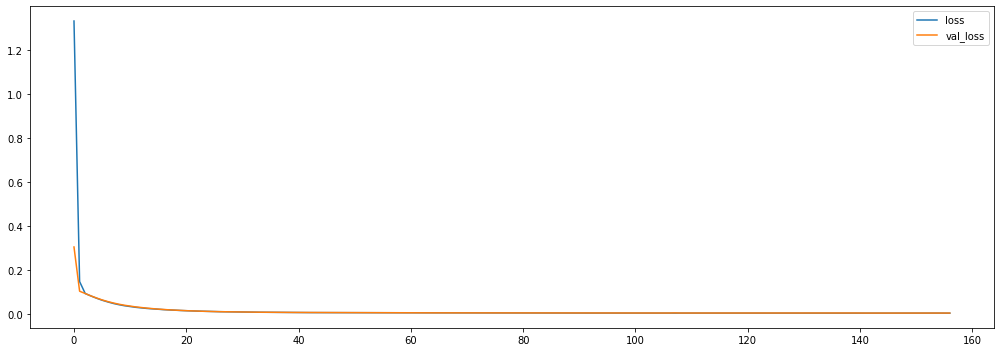

In [8]:
nn = cst.MLPRegressor(input_shape=len(attributes), hidden=[])
nn.compile(optimizer='Adam', loss='mse')
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = nn.fit(tr[attributes], tr[target], batch_size=32, epochs=200, verbose=0,
                 validation_split=0.2, callbacks=cb)
cst.plot_training_history(history, figsize=figsize)

## Baseline Evaluation

**...And let's check the results**

In [9]:
tr_pred = nn.predict(tr[attributes])
r2_tr = r2_score(tr[target], tr_pred)
mae_tr = mean_absolute_error(tr[target], tr_pred)
ts_pred = nn.predict(ts[attributes])
r2_ts = r2_score(ts[target], ts_pred)
mae_ts = mean_absolute_error(ts[target], ts_pred)
print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')
print(f'MAE: {mae_tr:.2f} (training), {mae_ts:.2f} (test)')

R2 score: 0.63 (training), 0.60 (test)
MAE: 0.05 (training), 0.06 (test)


* They are not super (definitely not [PreCrime](https://en.wikipedia.org/wiki/Minority_Report_(film)) level), but not alwful either
* Some improvements (not much) can be obtained with a Deeper model

**We will keep Linear Regression as a baseline**

* As a side benefit, we get to use an interpretable model!
* In particular, we can have evaluate the _importance of each input attribute_

This can be done in LR by _inspecting the weights_

# Important Attributes in Linear Regression

## Important Attributes in Linear Regression

**In particular, we can _plot the weights by decreasing (absolute) value_**

* If all attributes are standardized/normalized (so they have similar ranges)
* ...Then the larger then (absolute) weight, the larger the impact

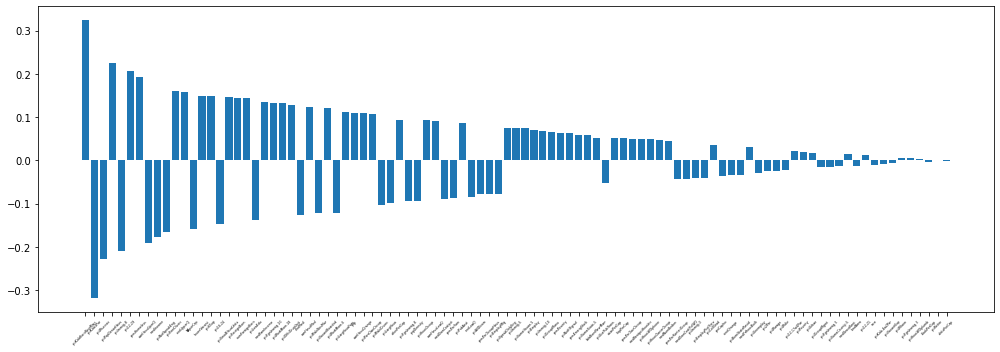

In [11]:
lr_weights = nn.get_weights()[0].ravel()
cst.plot_lr_weights(lr_weights, attributes, figsize=figsize)

* Unfortunately, if often happens that there are many large-ish weights

## Lasso

**We can fix this by adding an L1 regularizer to obtain [_LASSO (Regression)_](https://en.wikipedia.org/wiki/Lasso_(statistics))**

The regularizer penalizes large and small weights _with a fixed rate_

* Attributes for which the loss reduction does not match the regularization rate...
* ...Will be kept at zero, resulting in a _sparse weight vector_

**Lasso is available in scikit-learn, and can be implemented in Keras/Tensorflow**

In [16]:
nn2_in = layers.Input(len(attributes))
nn2_out = layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l1(l1=1e-3))(nn2_in)
nn2 = keras.Model(nn2_in, nn2_out)

* We obtain it from Linear Regression by introducing an L1 weight regularizer

## Lasso

**We can train the Lasso model as usual**

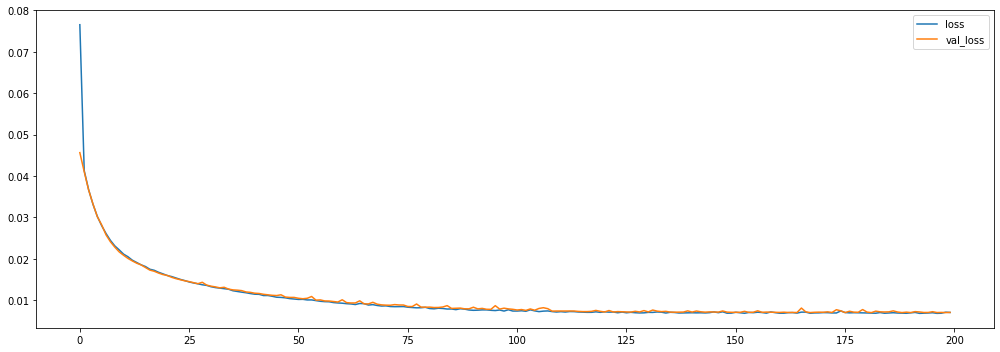

In [17]:
nn2.compile(optimizer='Adam', loss='mse')
cb2 = [callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
history2 = nn2.fit(tr[attributes], tr[target], batch_size=32, epochs=200, verbose=0,
                 validation_split=0.2, callbacks=cb2)
cst.plot_training_history(history2, figsize=figsize)

## Lasso Evaluation

**The results are on par with Linear Regression**

In [18]:
tr_pred2 = nn2.predict(tr[attributes])
r2_tr2 = r2_score(tr[target], tr_pred2)
mae_tr2 = mean_absolute_error(tr[target], tr_pred2)

ts_pred2 = nn2.predict(ts[attributes])
r2_ts2 = r2_score(ts[target], ts_pred2)
mae_ts2 = mean_absolute_error(ts[target], ts_pred2)

print(f'R2 score: {r2_tr2:.2f} (training), {r2_ts2:.2f} (test)')
print(f'MAE: {mae_tr2:.2f} (training), {mae_ts2:.2f} (test)')

R2 score: 0.62 (training), 0.59 (test)
MAE: 0.05 (training), 0.06 (test)


* The L1 term actually acts also as a traditional regularizer...
* ...And _may_ therefore help to prevent overfitting

## Important Attributes in Lasso

**The main difference between LR and Lasso is int the weight vector**

Lasso weights are _sparse_,  i.e. only a few attributes will have a significant impact

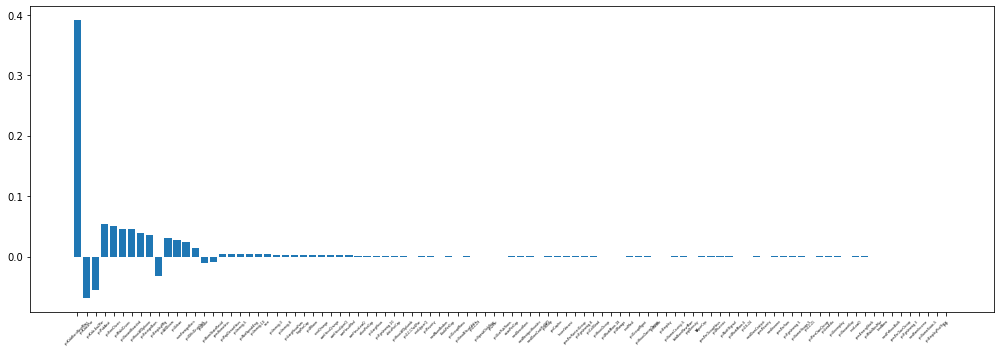

In [20]:
lasso_weights = nn2.get_weights()[0].ravel()
cst.plot_lr_weights(lasso_weights, attributes, figsize=figsize)

## Important Attributes in Lasso

**Let's zoom in on the 15 most important attributes**

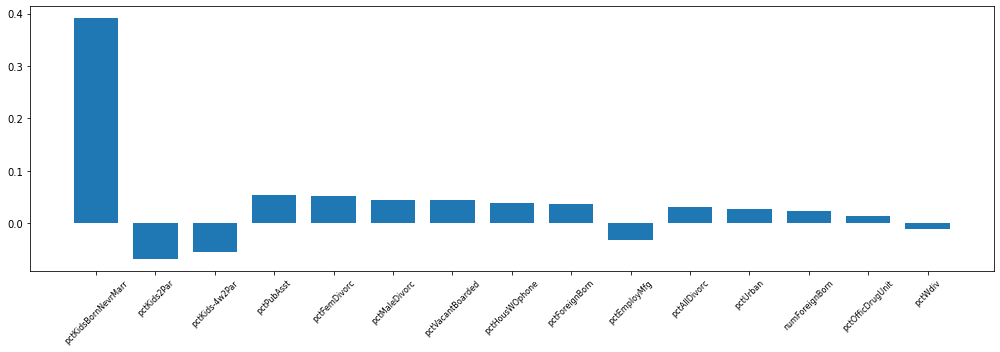

In [24]:
lasso_weights = nn2.get_weights()[0].ravel()
cst.plot_lr_weights(lasso_weights, attributes, cap_num=15, figsize=figsize)

The attribute "race" is nowhere to be seen!

* This is _looks_ reassuring for our potential discrimination concerns
* ...But in fact it is not (and we will proceed to check it)

# Fairness Constraints

## Discrimination Indexes

**Discrimination can be linked to _disparate treatment_**

* "Race" _may not be even among the input attributes_!
* ...Since it may be taken into account implicitly (i.e. via correlates)

**Indeed, our model _treats differently different groups_:**

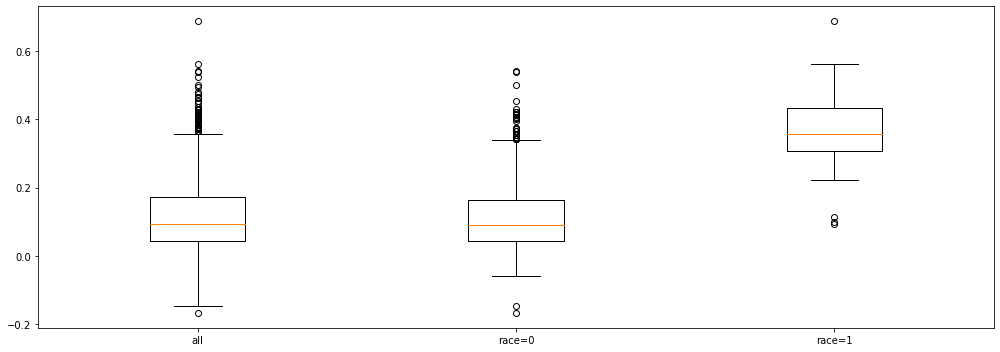

In [28]:
cst.plot_pred_by_protected(tr, tr_pred, protected={'race': (0, 1)}, figsize=figsize)

## Discrimination Indexes

**A number of _discrimination indexes_ attempt to measure discrimination**

* This is open research area: there is no clear best choice
* Whether ethics itself can be measured is _highly debatable_!

Even if imperfect, this currently the best we can do

**Classification and regression tasks usually call for different indexes**

Here's an example from a recent [AAAI paper](https://www.aaai.org/ojs/index.php/AAAI/article/download/3943/3821)

* Given a set of categorical _protected attribute (indexes) $J_p$_
* ...The regression form of the Disparate Impact Discrimination Index is given by:

$$
\text{DIDI}_r = \sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* Where $D_j$ is the domain of attribute $j$
* ...And $I_{j,v}$ is the set of example such that attribute $j$ has value $v$




## DIDI

**Let's make some intuitive sense of the $\text{DIDI}_r$ formula**

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* $\frac{1}{m} \sum_{i=1}^m y_i$ is just the average predicted value
* ...For examples where the protected attribute takes specific values
* $\frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}$ is the average prediction for a social group

**We penalize the group predictions for _deviating from the global average_**

* Obviously this is not necessarily the best definition, but it is something
* In general, different tasks will call for different discrimination indexes

...And don't forget the whole "can we actually measure ethics" issue ;-)

## DIDI

**We can compute the DIDI via the following function**

```python
def DIDI_r(data, pred, protected):
    res, avg = 0, np.mean(pred)
    for aname, dom in protected.items():
        for val in dom:
            mask = (data[aname] == val)
            res += abs(avg - np.mean(pred[mask]))
    return res
```

* `protected` contains the protected attribute names with their domain

**For our original Linear Regression model, we get**

In [29]:
tr_DIDI = cst.DIDI_r(tr, tr_pred, protected)
ts_DIDI = cst.DIDI_r(ts, ts_pred, protected)
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

DIDI: 0.25 (training), 0.27 (test)


This is our baseline discrimination level

## Fairness Constraints

**Discrimination indexes can be used to state fairness constraints**

For example, we may require:
$$
\text{DIDI}_r(y) \leq \theta
$$

**If the chosen index is _differentiable_...**

...Then we may try to inject the constraint via a _semantic regularizer_

* For example, we may use a loss function in the form:
$$
L(y, \hat{y}) + \lambda \max(0, \text{DIDI}_r(y) - \theta)
$$

For non-differentiable indexes (e.g. those found in classification), we can:

* Use a differentiable approximation (with some care!)
* Use an approach that does not require differentiability, e.g. [this](https://arxiv.org/abs/2002.10766) or [that](https://link.springer.com/content/pdf/10.1007/s10115-011-0463-8.pdf)



## Fairness as a Semantic Regularizer

**We can once again use a custom Keras model**

```python
class CstDIDIRegressor(MLPRegressor):
    def __init__(self, attributes, protected, alpha, thr, hidden=[]): ...

    def train_step(self, data): ...

    @property
    def metrics(self): ...
```

The full code can be found in the support module

* We subclass our `MLPRegressor` (itself a subclass of `keras.Model`)
* ...And we provide a custom training step
* `alpha` is the regularizer weight
* `thr` is the DIDI threshold

In this case, we do not need a custom batch generator

## Fairness as a Semantic Regularizer

**The main logic is in the first half of the `train_step` method:**

```python
def train_step(self, data):
    x, y_true = data # unpacking the mini-batch
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) # obtain predictions
        mse = self.compiled_loss(y_true, y_pred) # base loss (kept external)
        ymean = k.mean(y_pred) # avg prediction
        didi = 0 # DIDI computation
        for aidx, dom in self.protected.items():
            for val in dom:
                mask = (x[:, aidx] == val)
                didi += k.abs(ymean - k.mean(y_pred[mask]))
        cst = k.maximum(0.0, didi - self.thr) # Regularizer
        loss = mse + self.alpha * cst
```

* In this case we chose to let the main loss be defined externally
* ...Which means we will need to define it when calling `compile`

## Training the Constrained Model

**Let's try and train the model, trying to roughly halve the DIDI**

Important: it will be a good idea to need to keep all examples in every batch

* Using mini-batches makes constraint satisfaction (more) stochastic

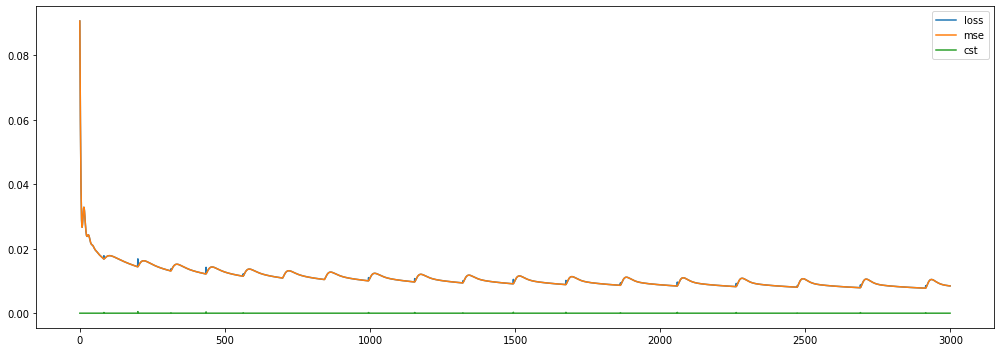

In [31]:
didi_thr = 0.13
nn3 = cst.CstDIDIRegressor(attributes, protected, alpha=5, thr=didi_thr, hidden=[])
nn3.compile(optimizer='Adam', loss='mse')
history3 = nn3.fit(tr[attributes], tr[target], batch_size=len(tr), epochs=3000, verbose=0)
cst.plot_training_history(history3, figsize=figsize)

## Constrained Model Evaluation

**Let's check both the prediction quality and the DIDI**

In [32]:
tr_pred3 = nn3.predict(tr[attributes])
r2_tr3 = r2_score(tr[target], tr_pred3)
mae_tr3 = mean_absolute_error(tr[target], tr_pred3)

ts_pred3 = nn3.predict(ts[attributes])
r2_ts3 = r2_score(ts[target], ts_pred3)
mae_ts3 = mean_absolute_error(ts[target], ts_pred3)

tr_DIDI3 = cst.DIDI_r(tr, tr_pred3, protected)
ts_DIDI3 = cst.DIDI_r(ts, ts_pred3, protected)

print(f'R2 score: {r2_tr3:.2f} (training), {r2_ts3:.2f} (test)')
print(f'MAE: {mae_tr3:.2f} (training), {mae_ts3:.2f} (test)')
print(f'DIDI: {tr_DIDI3:.2f} (training), {ts_DIDI3:.2f} (test)')

R2 score: 0.45 (training), 0.39 (test)
MAE: 0.06 (training), 0.07 (test)
DIDI: 0.09 (training), 0.09 (test)


* It seems _we have overdone it_: the constraint is satisfied with some slack
* ...And that came at the price of a strongly reduced predictive performance

**The issue is related to the choice of the _correct regularizer weight_**


# Lagrangian Dual Framework

## Choosing the Right Weight

**Choosing the regularizer weight in our setup is particularly tricky**

* Unlike in our RUL case study, we are not using domain knowledge...
* ...To enhance the prediction quality of the regressor

So, we cannot optimize some accuracy score on a separate validation set

**In fact, the fairness constraint and accuracy are _conflicting goals_**

* Satisfying the constraint has in this case higher priority
* So in principle we could resort to a lexicographic objective...
* ...But that kind of approach is prone to numerical issues

**A simpler, [recent approach](https://arxiv.org/abs/2001.09394) consists in relying on Lagrangian duality**


## Lagrangian Duality for Constrained ML

**Let's consider our semantic regularized loss**

$$
{\cal L}(y, \lambda) = L(y, \hat{y}) + \lambda \max\left(0, \text{DIDI}_r(y) - \theta \right)
$$

It can be generalized to:

$$
{\cal L}(y, \lambda) = L(y, \hat{y}) + \lambda \max\left(0, g(y) \right)
$$

* Where $g(y)$ is some kind of _constraint function_

**This is actually related to the constrained problem we really care about:**
$$
\min \{L(y, \hat{y}) \mid g(y) \leq 0 \}
$$

To be precise, the formulation is a _Lagrangian relaxation_

* Lagrangian relaxations are obtained by turning constraints into objective terms
* The above form applies to any differentiable inequality constraint
* ...With minor tweaks, equality constraints can also be handled

## Lagrangian Duality for Constrained ML

**Our regularized loss ${\cal L}(y, \lambda)$ is actually called a _Lagrangian_**

Specifically, the form somerimes in the [penalty method](https://en.wikipedia.org/wiki/Penalty_method#:~:text=Penalty%20methods%20are%20a%20certain,of%20the%20original%20constrained%20problem.)

$$
{\cal L}(y, \lambda) = L(y, \hat{y}) + \lambda \max\left(0, g(y) \right)
$$

Let's consider its relation with the original constrained formulation:

* Whenever the constraint is satisfied, we have that ${\cal L}(y, \lambda) = L(h, \hat{y})$
* ...No matter what what value $\lambda$ takes
* When the constraint is not satisfied, ${\cal L}(y, \lambda)$ will be higher than $L(y, \hat{y})$

**This means that, for any given $\lambda$, we have that:**

$$
\min_y {\cal L}(y, \lambda) \leq \min \{L(y, \hat{y}) \mid g(y) \leq 0 \}
$$

I.e. the relaxation optimum cannot be larger then the constrained optimum

* In fact, this is why it is called a "relaxation"

## Lagrangian Duality for Constrained ML

**So, for any $\lambda$, solving:**

$$
\min_y {\cal L}(y, \lambda)
$$

...Gives a _lower bound_ on the optimum of the constrained problem

**So, among many lower bounds why not taking _the largest one_?**

Formally, this means solving:

$$
\max_\lambda \left( \min_y {\cal L}(y, \lambda) \right)
$$

Intuitively:

* We choose $y$ to _minimize_ the Lagrangian (the "regularized loss")
* We choose $\lambda$ to _maximize_ the Lagrangian

This latter problem is known as _Lagrangian dual_

## Lagrangian Duality for Constrained ML

**This Lagrangian dual approach can be extremely powerful**

* It gives us _a criterion_ for choosing $\lambda$
* It can be (approximately) implemented _without an outer search loop_:
  - We can make one gradient step over $y$ to minimize $\cal L$
  - ...Then a second gradient step over $\lambda$ to maximize $\cal L$
* It is not limited to fairness constraints
  - It works for _any differentiable constraint_ function
  - ...And even when there are _many constraints_ with distinct weights
  - ...Which BTW in this context are called "multipliers"
* If the penalty terms is well chosen, the method has _convergence guarantees_
  - However, these are limited to fully convex setups
  - I.e. convex loss, model, and constraint function (like our case study!)
  - In practice, it is however often used as a heuristic
  

## Implementing the Lagrangian Dual Approach

**We will implement the Lagrangian dual approach via another custom model**

```python
class LagDualDIDIRegressor(MLPRegressor):
    def __init__(self, attributes, protected, thr, hidden=[]):
        super(LagDualDIDIRegressor, self).__init__(len(attributes), hidden)
        self.alpha = tf.Variable(0., name='alpha')
        ...

    def __custom_loss(self, x, y_true, sign=1): ...

    def train_step(self, data): ...
        
    def metrics(self): ...
```

* We no longer pass a fixed `alpha` weight/multiplier
* Instead we use a _trainable variable_

## Implementing the Lagrangian Dual Approach

**In the `__custom_loss` method we compute the Lagrangian/regularized loss**

```python
def __custom_loss(self, x, y_true, sign=1):
    y_pred = self(x, training=True) # obtain the predictions
    mse = self.compiled_loss(y_true, y_pred) # main loss
    ymean = k.mean(y_pred) # average prediction
    didi = 0 # DIDI computation
    for aidx, dom in self.protected.items():
        for val in dom:
            mask = (x[:, aidx] == val)
            didi += k.abs(ymean - k.mean(y_pred[mask]))
    cst = k.maximum(0.0, didi - self.thr) # regularizer
    loss = mse + self.alpha * cst
    return sign*loss, mse, cst
```

* The code is the same as before
* ...Except that we can flip the loss sign via a function argument (i.e. `sign`)

## Implementing the Lagrangian Dual Approach

**In the training method, we make _two distinct gradient steps:_**

```python
    def train_step(self, data):
        x, y_true = data # unpacking
        with tf.GradientTape() as tape: # first loss (minimization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=1)
        # Separate training variables
        tr_vars = self.trainable_variables
        wgt_vars = tr_vars[:-1] # network weights
        mul_vars = tr_vars[-1:] # multiplier
        grads = tape.gradient(loss, wgt_vars) # adjust the network weights
        self.optimizer.apply_gradients(zip(grads, wgt_vars))
        with tf.GradientTape() as tape: # second loss (maximization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=-1)
        grads = tape.gradient(loss, mul_vars) # adjust lambda
        self.optimizer.apply_gradients(zip(grads, mul_vars))
```

* In principle, we could even have used two distinct optimizers
* That would allow to keep (e.g.) separate momentum vectors

## Training the Lagrangian Dual Approach

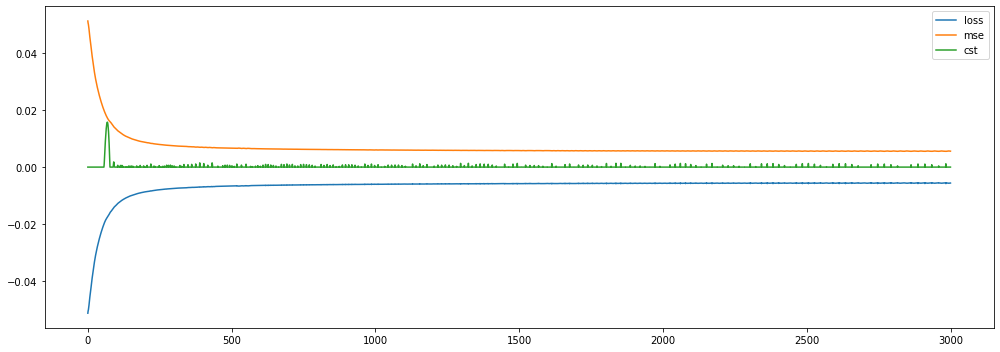

In [34]:
nn4 = cst.LagDualDIDIRegressor(attributes, protected, thr=didi_thr, hidden=[])
nn4.compile(optimizer='Adam', loss='mse')
history4 = nn4.fit(tr[attributes], tr[target], batch_size=len(tr), epochs=3000, verbose=0)

cst.plot_training_history(history4, figsize=figsize)

## Lagrangian Dual Evaluation

**Let's check the new results**

In [35]:
tr_pred4 = nn4.predict(tr[attributes])
r2_tr4 = r2_score(tr[target], tr_pred4)
mae_tr4 = mean_absolute_error(tr[target], tr_pred4)

ts_pred4 = nn4.predict(ts[attributes])
r2_ts4 = r2_score(ts[target], ts_pred4)
mae_ts4 = mean_absolute_error(ts[target], ts_pred4)

print(f'R2 score: {r2_tr4:.2f} (training), {r2_ts4:.2f} (test)')
print(f'MAE: {mae_tr4:.2f} (training), {mae_ts4:.2f} (test)')

tr_DIDI4 = cst.DIDI_r(tr, tr_pred4, protected)
ts_DIDI4 = cst.DIDI_r(ts, ts_pred4, protected)
print(f'DIDI: {tr_DIDI4:.2f} (training), {ts_DIDI4:.2f} (test)')

R2 score: 0.63 (training), 0.56 (test)
MAE: 0.05 (training), 0.06 (test)
DIDI: 0.12 (training), 0.13 (test)


* The DIDI has the desired value (on the test set, this is only roughly true)
* ...And the prediction quality is _much higher_ (close to the original value)

All this with only a slightly higher computational cost

## Final Considerations

**The idea of injecting constraints in ML is attracting research interest**

* It can be used to take advantage of domain/symbolic knowledge
* It can be used to improve reliability and fairness

**We haven't covered all possible approaches**

* E.g. it is possible to incorporate constraints in the model structure
* ...Or using constraints to correct the model output
* A recent buzzword to watch for: neuro-symbolic integration

**It is still an active research topic, with many open issues**

* E.g. how to deal with non-differentiable constraints (project works available)
* E.g. how to deal with large scale relational constraints (such as fairness ones)
* E.g. how to tune/learn constraint multipliers for soft constraint
* ...